Based on [this tutorial](https://www.learnpytorch.io/03_pytorch_computer_vision/)


---

In [1]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")


PyTorch version: 2.2.1
torchvision version: 0.17.1


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# Import FashionMNIST Data

In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(), # convert images in PIL format to tensors
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

## Exploring the data

In [4]:
image,label = train_data[0]
image,label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

In [5]:
image.shape

torch.Size([1, 28, 28])

This stands for 1 color channel and the size of picture which is 28x28

In [6]:
len(train_data.data), len(test_data.data)

(60000, 10000)

In [7]:
train_data.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [8]:
class_names = train_data.classes


Text(0.5, 1.0, 'Ankle boot')

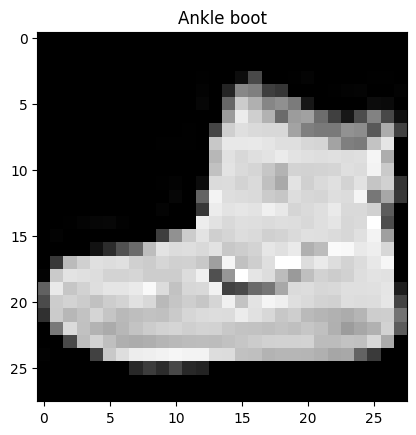

In [9]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap='gray')
plt.title(train_data.classes[label])

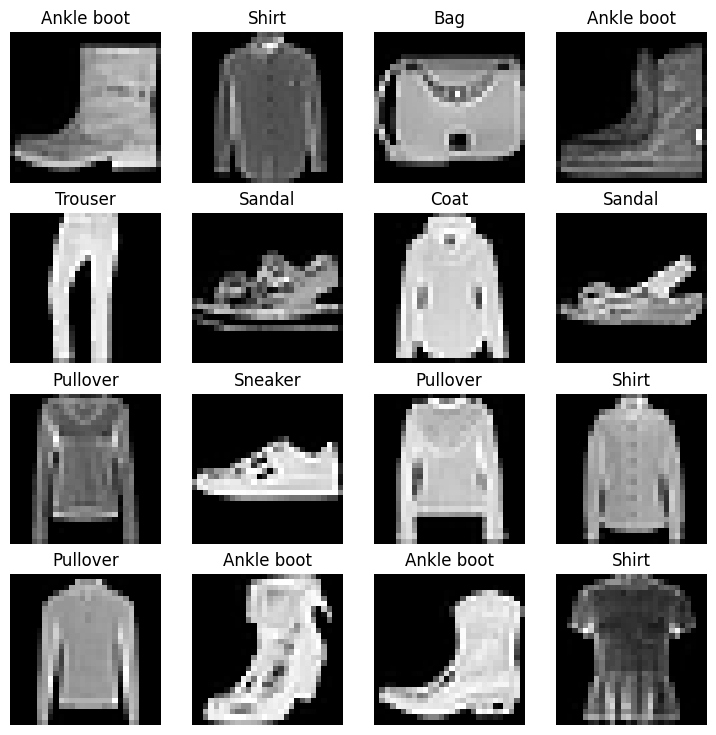

In [10]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(train_data.classes[label])
    plt.axis(False);

# Preparing data with `DataLoader`

This function prepares the data for loading it into a model (for training and inference). It turns a large dataset into a python iterable of mini batches

In [11]:
from torch.utils.data import DataLoader

# it is prefered to use powers of 2. however, 32 is the prefered option
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,               
                            batch_size=BATCH_SIZE,  # batch size for each gradient descent step
                            shuffle=True            # shuffle data every epoch
)

test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


print(f"Length of train dataloader: {len(train_dataloader)} batches")
print(f"Length of test dataloader: {len(test_dataloader)} batches")

Length of train dataloader: 1875 batches
Length of test dataloader: 313 batches


Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


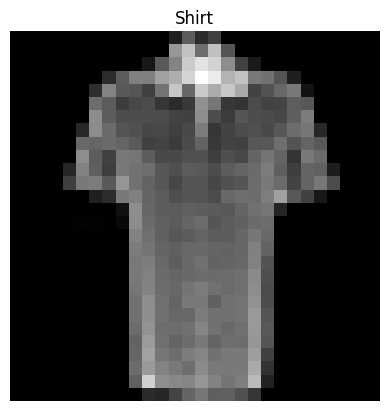

In [12]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))


torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

# Model 0: building the baseline model

First,, we'll use `nn.Flatten()` layer in the baseline model which compresses the dimensions of a tensor into a single vector called **feature vector**

In [13]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")


Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]


Next, the feature vector will be passed to a `Linear` layer

In [14]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [15]:
model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names))

model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [16]:
!pip install torchmetrics

In [17]:
from torchmetrics.classification import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes = len(class_names))

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

c:\Users\H\.conda\envs\ml\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [18]:
from timeit import default_timer as timer

def print_train_time(start: float, end: float, device: torch.device = None):
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} secs")
    return total_time



In [19]:
from tqdm.auto import tqdm

torch.manual_seed(42)
train_time_start_on_cpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")


    train_loss = 0

    # calculate loss and run SGD for each mini batch
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()


        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)} / {len(train_dataloader.dataset)} samples")
    
    # average loss per batch per epoch
    train_loss /= len(train_dataloader)

    ### Testing

    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)

            test_loss += loss_fn(test_pred, y)

            test_acc += accuracy_fn(test_pred, y)
        
        test_loss /= len(test_dataloader)

        test_acc /= len(test_dataloader)
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


train_time_end_on_cpu = timer()

total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                            end=train_time_end_on_cpu,
                                            device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 33%|███▎      | 1/3 [00:10<00:20, 10.19s/it]


Train loss: 0.59484 | Test loss: 0.51635, Test acc: 0.82%

Epoch: 1
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


 67%|██████▋   | 2/3 [00:19<00:09,  9.95s/it]


Train loss: 0.47946 | Test loss: 0.48138, Test acc: 0.83%

Epoch: 2
-------
Looked at 0 / 60000 samples
Looked at 12800 / 60000 samples
Looked at 25600 / 60000 samples
Looked at 38400 / 60000 samples
Looked at 51200 / 60000 samples


100%|██████████| 3/3 [00:29<00:00,  9.86s/it]


Train loss: 0.45703 | Test loss: 0.47773, Test acc: 0.83%

Train time on cpu: 29.595 secs


In [77]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn):

    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


In [90]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

model_0_results

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

# Model 1: Building a better model with non-linearity

In [21]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [22]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784,
                                hidden_units=10,
                                output_shape=len(class_names)).to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

In [23]:
from torchmetrics.classification import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [24]:
def train_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                accuracy_fn,
                device: torch.device = device):
    
    train_loss, train_acc = 0, 0
    model.to(device)

    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):

    test_loss, test_acc = 0, 0
    model.to(device)

    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)

            test_pred = model(X)

            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(test_pred.argmax(dim=1), y).item()
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")




In [25]:
torch.manual_seed(42)

from timeit import default_timer as Timer
train_time_start_on_gpu = timer()

epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )

    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(train_time_start_on_gpu, train_time_end_on_gpu, device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 0.61%


 33%|███▎      | 1/3 [00:18<00:37, 18.62s/it]

Test loss: 0.95637 | Test accuracy: 0.65%

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 0.72%


 67%|██████▋   | 2/3 [00:34<00:16, 16.87s/it]

Test loss: 0.72227 | Test accuracy: 0.74%

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 0.76%


100%|██████████| 3/3 [00:49<00:00, 16.62s/it]

Test loss: 0.68500 | Test accuracy: 0.75%

Train time on cuda: 49.872 secs


In [79]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
                device: torch.device = device):

    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_pred.argmax(dim=1), y)

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}



In [89]:
model_1_results = eval_model(model=model_1, data_loader=test_dataloader, loss_fn=loss_fn, accuracy_fn=accuracy_fn)

model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008368492126,
 'model_acc': tensor(0.7502, device='cuda:0')}

# Model 2: building a convultional neural network (CNN)

We'll use TinyVGG

In [28]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)

        x = self.block_2(x)

        x = self.classifier(x)

        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names)).to(device)

model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## Testing the layers effect

In [32]:
# create a batch of 32 random images 

torch.manual_seed(42)

images = torch.randn(size=(32,3,64,64))
test_image = images[0]
test_image.shape

torch.Size([3, 64, 64])

In [42]:
torch.manual_seed(42)

conv_layer = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=1, padding=0)

conv_layer(test_image).shape

torch.Size([10, 62, 62])

In [46]:
max_pool_layer = nn.MaxPool2d(kernel_size=2)

test_image_through_conv_and_max_pool = max_pool_layer(conv_layer(test_image))
test_image_through_conv_and_max_pool.shape

torch.Size([10, 31, 31])

## Training and testing `model_2`

In [47]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [48]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_2 = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----")

    train_step(
        data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )

    test_step(
        data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(
    start=train_time_start_model_2,
    end=train_time_end_model_2,
    device=device
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-----
Train loss: 0.58612 | Train accuracy: 0.79%


 33%|███▎      | 1/3 [00:21<00:42, 21.46s/it]

Test loss: 0.39381 | Test accuracy: 0.86%

Epoch: 1
-----
Train loss: 0.36137 | Train accuracy: 0.87%


 67%|██████▋   | 2/3 [00:38<00:19, 19.01s/it]

Test loss: 0.34448 | Test accuracy: 0.87%

Epoch: 2
-----
Train loss: 0.32542 | Train accuracy: 0.88%


100%|██████████| 3/3 [00:55<00:00, 18.54s/it]

Test loss: 0.32420 | Test accuracy: 0.88%

Train time on cuda: 55.628 secs


In [88]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3241972327232361,
 'model_acc': tensor(0.8823, device='cuda:0')}

In [85]:
model_0_results['model_acc'].cpu().float()

tensor(0.8350)

In [91]:
import pandas as pd

model_0_results['model_acc'] = model_0_results['model_acc'].item()
model_1_results['model_acc'] = model_1_results['model_acc'].item()
model_2_results['model_acc'] = model_2_results['model_acc'].item()

compare_res = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_res

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.477732,0.834964
1,FashionMNISTModelV1,0.685001,0.750200
2,FashionMNISTModelV2,0.324197,0.882288


<Axes: ylabel='model_name'>

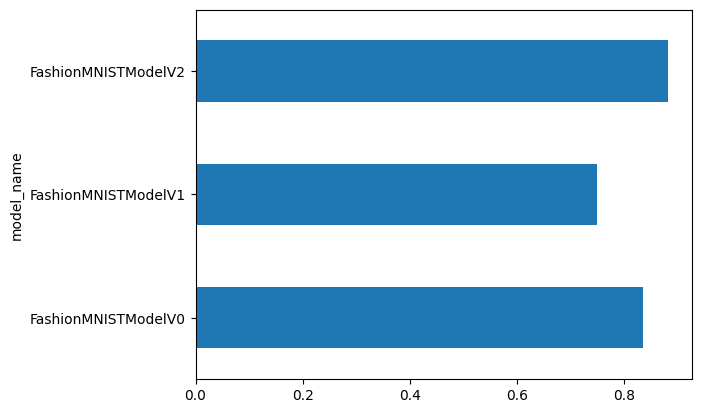

In [94]:
compare_res.set_index("model_name")["model_acc"].plot(kind='barh')

## Evaluate random predictions with the best model

In [104]:
def make_preds(model, data, device=device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)

            pred_logit = model(sample)

            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            pred_probs.append(pred_prob.cpu())

    return torch.stack(pred_probs)

In [105]:
import random

random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"test sample image shape: {test_samples[0].shape}")
print(f"test sample label shape: {test_labels[0]}")
print(f"test sample label: {class_names[test_labels[0]]}")

test sample image shape: torch.Size([1, 28, 28])
test sample label shape: 5
test sample label: Sandal


In [109]:
pred_probs = make_preds(model=model_2, data=test_samples)

pred_probs[:2]

tensor([[2.0352e-07, 8.2677e-08, 8.9616e-08, 5.6028e-07, 2.8803e-08, 9.9993e-01,
         8.4049e-07, 1.5112e-05, 1.8091e-05, 3.8393e-05],
        [1.8410e-02, 5.9425e-01, 6.3934e-04, 1.5051e-01, 7.3433e-02, 1.3801e-04,
         1.6134e-01, 1.9155e-04, 5.7780e-04, 5.1361e-04]])

In [113]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

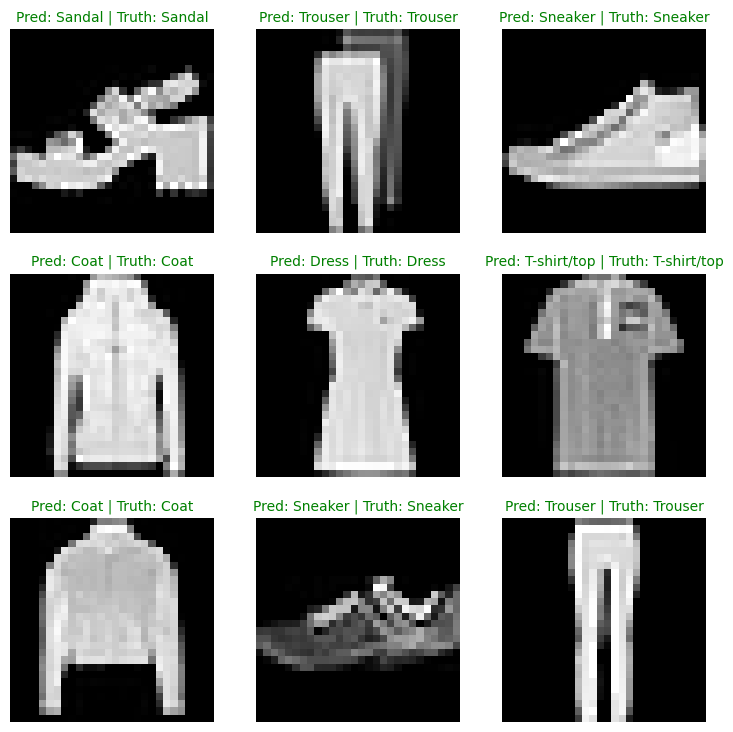

In [114]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)

    plt.imshow(sample.squeeze(), cmap='gray')

    pred_label = class_names[pred_classes[i]]

    truth_label = class_names[test_labels[i]]

    title_text = f"Pred: {pred_label} | Truth: {truth_label}" 

    if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
    plt.axis(False)

## Evaluate with confusion matrix

### 1. Make predictions

In [115]:
from tqdm.auto import tqdm

y_preds = []
model_2.eval()

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions"):
        X, y = X.to(device), y.to(device)
        y_logit = model_2(X)
        y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
        y_preds.append(y_pred.cpu())

y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:01<00:00, 161.51it/s]


In [117]:
y_pred_tensor

tensor([9, 2, 1,  ..., 8, 1, 8])

### 2. Make confusion matrix

In [116]:
try:
    import torchmetrics, mlxtend
    assert int(mlxtend.__version__.split(".")[1]) >= 19
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.23.1


In [118]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor, target=test_data.targets)

### 3. Plot confusion matrix

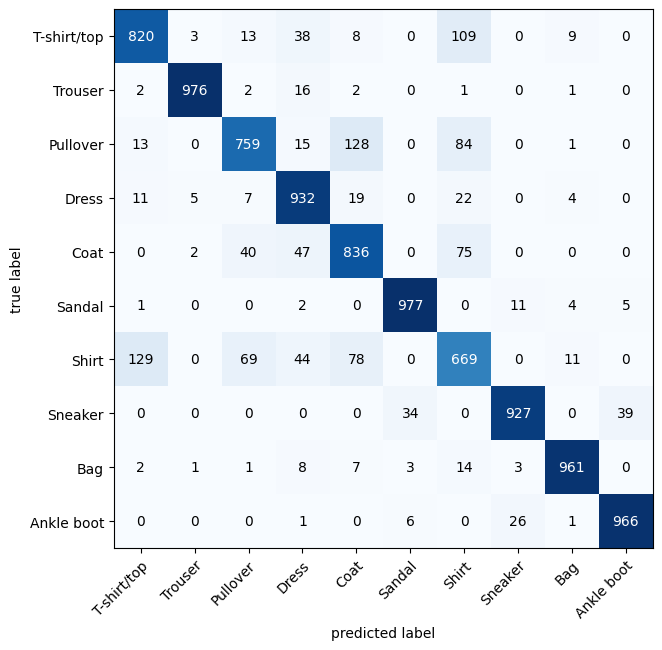

In [119]:
fix, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

# Save the best performing model

In [120]:
from pathlib import Path
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "03_pytorch_computer_vision_model_2_tinyvgg.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models\03_pytorch_computer_vision_model_2_tinyvgg.pth
